In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Variational Auto encoders

#### Setting the device for training

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Enabled:",torch.cuda.is_available())

GPU Enabled: True


### Defining Pytorch dataset and loader

In [3]:
BATCH_SIZE = 512

if torch.cuda.is_available():
    NUM_WORKERS = 64
else:
    NUM_WORKERS = 4

In [4]:
# Training dataset and dataloader
dataset = datasets.MNIST(
    root='../../../datasets',
    download=True,
    train = True,
    transform=transforms.ToTensor()
)


loader = DataLoader(
    dataset,
    num_workers=64,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation dataset and dataloader
val_dataset = datasets.MNIST(
    root='../../../datasets',
    download=True,
    train = False,
    transform=transforms.ToTensor()
)

val_loader = DataLoader(
    val_dataset,
    num_workers=64,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#### Checking dataset size

In [5]:
len(loader.dataset), len(val_loader.dataset)

(60000, 10000)

## Define VAE architecture

In this part, we are going to implement a simple VAE. We will base our implementation on the following figure and we will subdivise the network into 4 parts:

- Part 1 (Encoder Q): This part will be a stack of two fully connected lowers with 256 and 128 neurons
- Part 2 (Mean and Variance vectors): These two variables will be implemented as fully connected layers that maps the dimentions of the output of the Encoder to the dimensions of our latent space.
- Part 3 (latent_mapping): Illustrated as P in the following Figure, this part will map our simple latent distribution (Gaussian distribution) into a more complex one which actually represent the real latent space generated from the data.
- Part 4 (Decoder) : Illustrated by f in the Figure, this part will map our complex latent space into the distribution of our real data. This part will be a stack of two fully connected layers with 128 and 256 neurons 

![](notes/imgs/vae-detailed-architecture-notebook.png)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 128))
        
        self.mu     = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, 128)
        
        self.decoder = nn.Sequential(nn.Linear(128, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 28 * 28))
        
        
    def encode(self, x):
        x = x.view(x.size(0), -1)
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
        
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z,x):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        reshaped_out = torch.sigmoid(out).view(x.shape[0],1, 28,28)
        return reshaped_out
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z,x)
        
        return output

### Helper function to visualize how the network perform during training on validation data

In [7]:
def show_summary(valid_dl, model):
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            recon_x = model(x.unsqueeze(0).to(device)).cpu()
            preds.append(recon_x.squeeze(0))
            
            if i + 1 == N_SAMPLES:
                break
                
    model.train()
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

### Define training loss

In [8]:
def elbo_loss(x_generated, x_true, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_generated, x_true, reduction='none').sum(dim=(1, 2, 3))
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)
    loss = torch.mean(kld_loss + recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

In [9]:
vae_net = VAE(latent_dim=2)

In [10]:
opt = torch.optim.Adam(vae_net.parameters())

### Let's train the VAE that we impelmented

[epoch 1] loss: 13.452 reconstruction loss: 13.110 KLD loss: 0.342


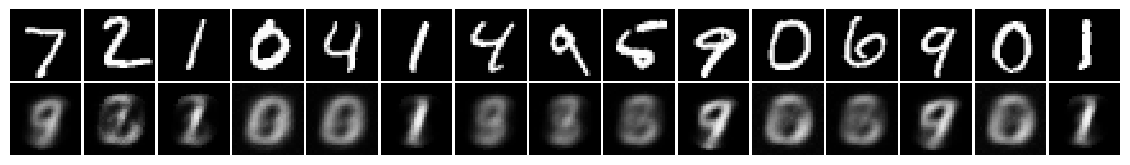

[epoch 2] loss: 9.837 reconstruction loss: 9.600 KLD loss: 0.236
[epoch 3] loss: 9.284 reconstruction loss: 8.973 KLD loss: 0.310
[epoch 4] loss: 9.039 reconstruction loss: 8.692 KLD loss: 0.347
[epoch 5] loss: 8.890 reconstruction loss: 8.521 KLD loss: 0.369
[epoch 6] loss: 8.773 reconstruction loss: 8.385 KLD loss: 0.389
[epoch 7] loss: 8.686 reconstruction loss: 8.283 KLD loss: 0.403
[epoch 8] loss: 8.617 reconstruction loss: 8.201 KLD loss: 0.415
[epoch 9] loss: 8.541 reconstruction loss: 8.113 KLD loss: 0.427
[epoch 10] loss: 8.486 reconstruction loss: 8.049 KLD loss: 0.438
[epoch 11] loss: 8.451 reconstruction loss: 8.006 KLD loss: 0.445


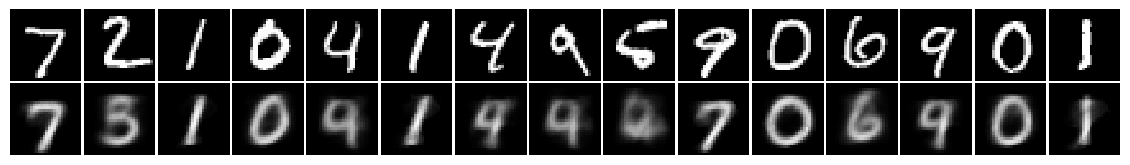

[epoch 12] loss: 8.407 reconstruction loss: 7.954 KLD loss: 0.453
[epoch 13] loss: 8.359 reconstruction loss: 7.900 KLD loss: 0.459
[epoch 14] loss: 8.343 reconstruction loss: 7.876 KLD loss: 0.467
[epoch 15] loss: 8.310 reconstruction loss: 7.836 KLD loss: 0.474
[epoch 16] loss: 8.275 reconstruction loss: 7.796 KLD loss: 0.479
[epoch 17] loss: 8.253 reconstruction loss: 7.768 KLD loss: 0.484
[epoch 18] loss: 8.228 reconstruction loss: 7.739 KLD loss: 0.489
[epoch 19] loss: 8.216 reconstruction loss: 7.722 KLD loss: 0.494
[epoch 20] loss: 8.192 reconstruction loss: 7.696 KLD loss: 0.496
[epoch 21] loss: 8.165 reconstruction loss: 7.663 KLD loss: 0.502


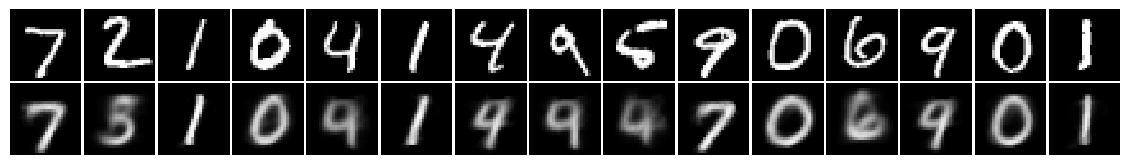

[epoch 22] loss: 8.152 reconstruction loss: 7.645 KLD loss: 0.507
[epoch 23] loss: 8.144 reconstruction loss: 7.635 KLD loss: 0.509
[epoch 24] loss: 8.130 reconstruction loss: 7.615 KLD loss: 0.515
[epoch 25] loss: 8.106 reconstruction loss: 7.589 KLD loss: 0.517
[epoch 26] loss: 8.094 reconstruction loss: 7.572 KLD loss: 0.522
[epoch 27] loss: 8.068 reconstruction loss: 7.545 KLD loss: 0.524
[epoch 28] loss: 8.058 reconstruction loss: 7.531 KLD loss: 0.528
[epoch 29] loss: 8.045 reconstruction loss: 7.516 KLD loss: 0.529
[epoch 30] loss: 8.036 reconstruction loss: 7.503 KLD loss: 0.532
[epoch 31] loss: 8.028 reconstruction loss: 7.493 KLD loss: 0.535


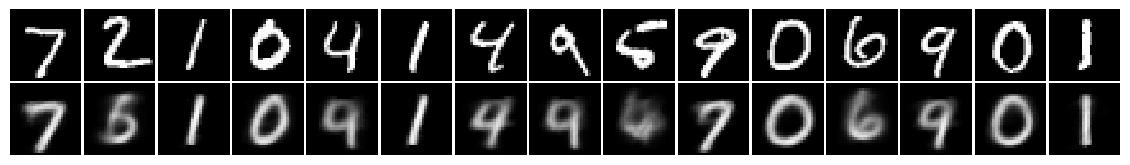

[epoch 32] loss: 8.005 reconstruction loss: 7.466 KLD loss: 0.539
[epoch 33] loss: 7.996 reconstruction loss: 7.456 KLD loss: 0.540
[epoch 34] loss: 7.987 reconstruction loss: 7.444 KLD loss: 0.543
[epoch 35] loss: 7.972 reconstruction loss: 7.427 KLD loss: 0.545
[epoch 36] loss: 7.970 reconstruction loss: 7.423 KLD loss: 0.547
[epoch 37] loss: 7.956 reconstruction loss: 7.408 KLD loss: 0.548
[epoch 38] loss: 7.955 reconstruction loss: 7.404 KLD loss: 0.550
[epoch 39] loss: 7.935 reconstruction loss: 7.381 KLD loss: 0.553
[epoch 40] loss: 7.924 reconstruction loss: 7.371 KLD loss: 0.554
[epoch 41] loss: 7.917 reconstruction loss: 7.362 KLD loss: 0.555


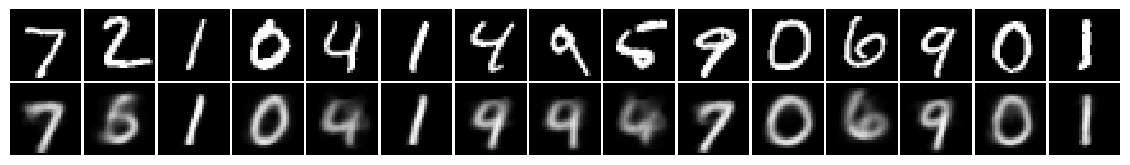

[epoch 42] loss: 7.913 reconstruction loss: 7.355 KLD loss: 0.558
[epoch 43] loss: 7.904 reconstruction loss: 7.342 KLD loss: 0.562
[epoch 44] loss: 7.887 reconstruction loss: 7.326 KLD loss: 0.561
[epoch 45] loss: 7.891 reconstruction loss: 7.328 KLD loss: 0.563
[epoch 46] loss: 7.880 reconstruction loss: 7.315 KLD loss: 0.565
[epoch 47] loss: 7.870 reconstruction loss: 7.306 KLD loss: 0.565
[epoch 48] loss: 7.866 reconstruction loss: 7.298 KLD loss: 0.568
[epoch 49] loss: 7.863 reconstruction loss: 7.292 KLD loss: 0.571
[epoch 50] loss: 7.845 reconstruction loss: 7.273 KLD loss: 0.572
[epoch 51] loss: 7.839 reconstruction loss: 7.266 KLD loss: 0.572


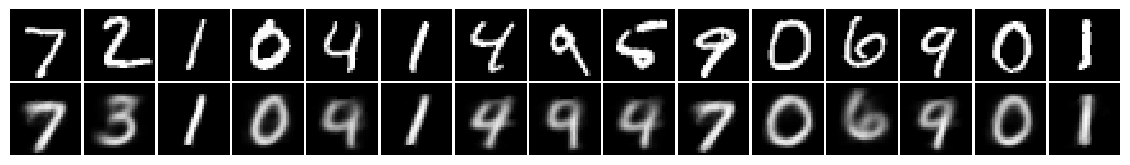

[epoch 52] loss: 7.834 reconstruction loss: 7.258 KLD loss: 0.576
[epoch 53] loss: 7.827 reconstruction loss: 7.251 KLD loss: 0.577
[epoch 54] loss: 7.827 reconstruction loss: 7.249 KLD loss: 0.578
[epoch 55] loss: 7.811 reconstruction loss: 7.233 KLD loss: 0.578
[epoch 56] loss: 7.817 reconstruction loss: 7.235 KLD loss: 0.582
[epoch 57] loss: 7.800 reconstruction loss: 7.221 KLD loss: 0.579
[epoch 58] loss: 7.807 reconstruction loss: 7.224 KLD loss: 0.583
[epoch 59] loss: 7.780 reconstruction loss: 7.197 KLD loss: 0.583
[epoch 60] loss: 7.783 reconstruction loss: 7.198 KLD loss: 0.585


In [11]:
loss_arr = []
loss_rec = []
loss_kdl = []

max_epochs = 60

vae_net = vae_net.to(device)

for epoch in range(max_epochs):
    
    running_loss = 0.0
    running_loss_rec = 0.0
    running_loss_kdl = 0.0
    
    for i, data in enumerate(loader, 0):

        inputs, labels = data

        inputs = inputs.to(device)
        
        # training steps for normal model
        opt.zero_grad()
        
        mu, logvar = vae_net.encode(inputs)
        z = vae_net.sample_z(mu, logvar)
        outputs = vae_net.decode(z, inputs)

        loss, recon_loss, kld_loss = elbo_loss(outputs, inputs, mu, logvar)
        loss.backward()
        opt.step()
        
        
        loss_arr.append(loss.item())
        loss_rec.append(recon_loss.item())
        loss_kdl.append(kld_loss.item())
        
        # print statistics
        running_loss += loss.item()
        running_loss_rec += recon_loss.item()
        running_loss_kdl += kld_loss.item()

    print('[epoch %d] loss: %.3f reconstruction loss: %.3f KLD loss: %.3f'\
          %(epoch + 1, np.mean(np.array(running_loss))/BATCH_SIZE,\
            np.mean(np.array(running_loss_rec))/BATCH_SIZE, np.mean(np.array(running_loss_kdl))/BATCH_SIZE))
    if epoch%10 == 0:
        show_summary(val_loader, vae_net)
    running_loss = 0.0
    running_loss_rec = 0.0
    running_loss_kdl = 0.0
            
    print("="*60)

#### Helper function to vizualize the latent space with labels

In [12]:
def viz_vae_clusters(vae_net):

    vae_net.to(device)
    z, labels = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            x = x.to(device)
            mu, _ = vae_net.encode(x)
            z.append(mu.cpu())
            labels.append(y)
    z = torch.cat(z, dim=0)
    labels = torch.cat(labels, dim=0)

    df = pd.DataFrame({'x': z[:,0].numpy(), 
                  'y': z[:,1].numpy(),
                  'label': labels.numpy()})

    plt.figure(figsize=(15, 15))
    sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
    plt.title('Vizualising Latent Vectors');

# Visualizing the continuity of the latent space

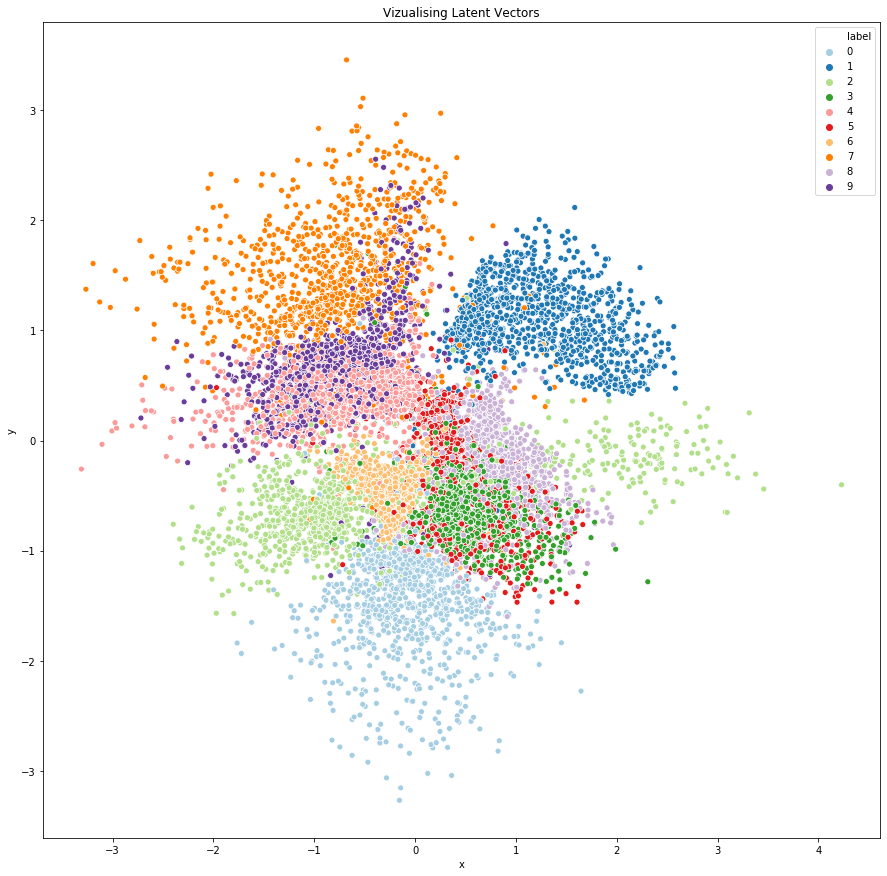

In [13]:
viz_vae_clusters(vae_net)

In [14]:
def draw_mnist_manifold_vae(model, size = 20):

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = norm.ppf(np.linspace(0.05, 0.95, size))
    y_axes = norm.ppf(np.linspace(0.05, 0.95, size))

    # preparing input to decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    
    # decoding latent vectors
    z = torch.stack(z)
    
    # decoding latent vectors
    preds = model.decode(z,z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()

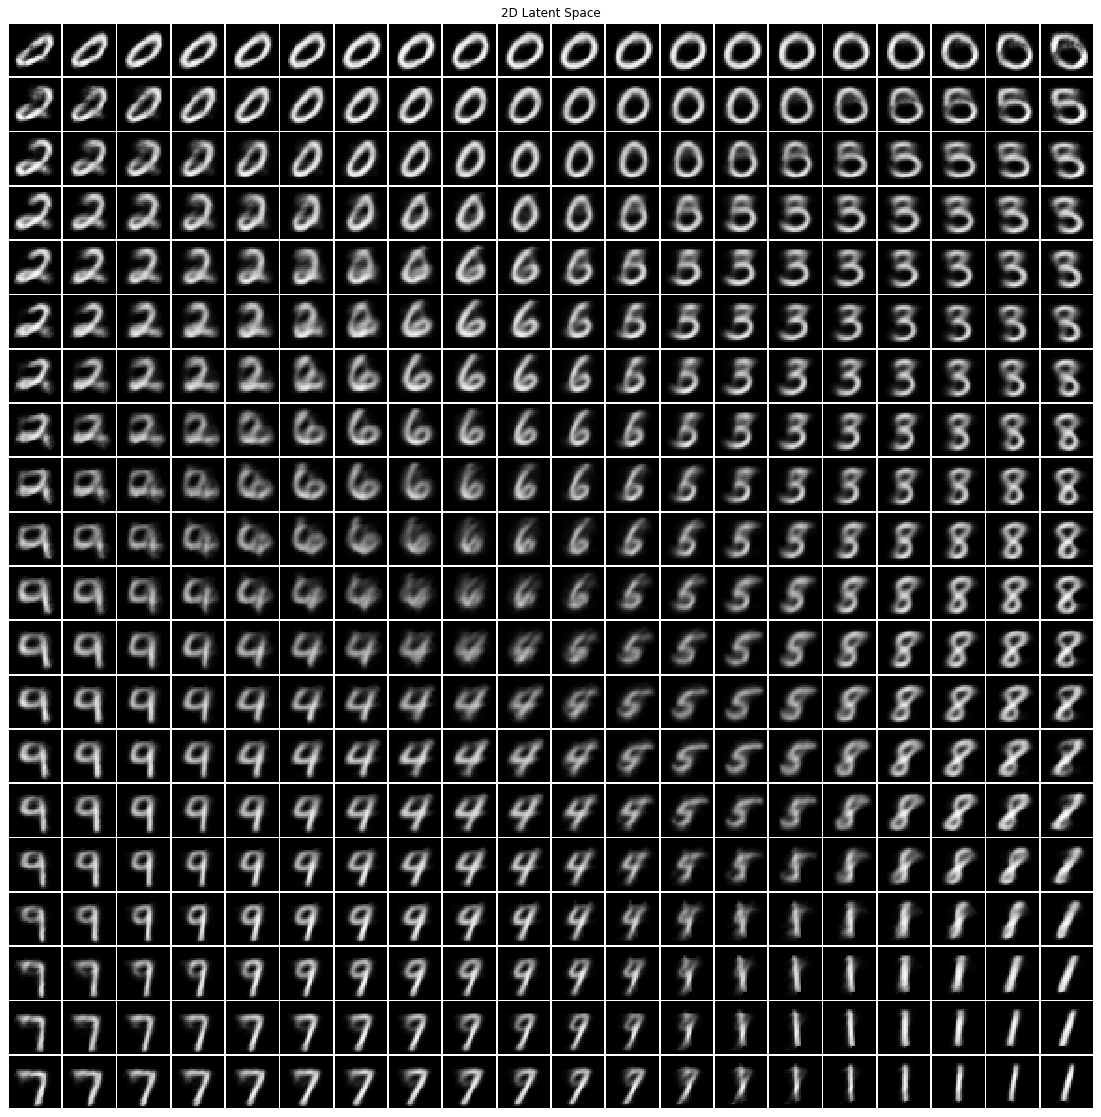

In [15]:
draw_mnist_manifold_vae(vae_net.cpu());